In [9]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import ion
import matplotlib.dates as mdates
%matplotlib tk
import numpy as np
from poliastro.bodies import Sun
from poliastro.core.iod import izzo
from datetime import datetime
from tqdm import tqdm
from scipy.ndimage import binary_dilation
import matplotlib.font_manager as fm
from lamberthub import izzo2015,vallado2013
from matplotlib.ticker import MultipleLocator , MaxNLocator

In [10]:
targets = ['SUN', 'EARTH', 'MARS', 'SATELLITE']

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('X (AU)')
ax.set_ylabel('Y (AU)')
ax.set_zlabel('Z (AU)')
ax.set_title('Orbit in AU Space')

all_px, all_py, all_pz = [], [], []

for target in targets:
    try :
        data = np.genfromtxt(f'simulation_results/{target}.csv', delimiter=',', skip_header=1)
    except :
        data = np.genfromtxt(f'traces/{target}.csv', delimiter=',', skip_header=1)
        
    px, py, pz = data[:, 1], data[:, 2], data[:, 3]
    
    all_px.extend(px)
    all_py.extend(py)
    all_pz.extend(pz)
    
    ax.plot(px, py, pz, label=target)  # Add label for better visualization

# Compute overall range
all_px, all_py, all_pz = np.array(all_px), np.array(all_py), np.array(all_pz)

max_range = max(all_px.ptp(), all_py.ptp(), all_pz.ptp()) / 2.0
mid_x = (all_px.max() + all_px.min()) / 2.0
mid_y = (all_py.max() + all_py.min()) / 2.0
mid_z = (all_pz.max() + all_pz.min()) / 2.0

# Set the global limits
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

ax.legend()  # Show labels

#plt.show()
print('done')

3

In [11]:
def load_data(host : str, target : str) :
    
    try :
        dates = np.genfromtxt(f'simulation_results\{host}.csv',delimiter=',',usecols=[0],skip_header=True,dtype=str) 

        host_positions = np.genfromtxt(f'simulation_results\{host}.csv',delimiter=',',usecols=[1,2,3],skip_header=True) 
        host_velocities = np.genfromtxt(f'simulation_results\{host}.csv',delimiter=',',usecols=[4,5,6],skip_header=True)

        target_positions = np.genfromtxt(f'simulation_results\{target}.csv',delimiter=',',usecols=[1,2,3],skip_header=True) 
        target_velocities = np.genfromtxt(f'simulation_results\{target}.csv',delimiter=',',usecols=[4,5,6],skip_header=True)  
    
    except : 
        dates = np.genfromtxt(f'traces\{host}.csv',delimiter=',',usecols=[0],skip_header=True,dtype=str) 

        host_positions = np.genfromtxt(f'traces\{host}.csv',delimiter=',',usecols=[1,2,3],skip_header=True) 
        host_velocities = np.genfromtxt(f'traces\{host}.csv',delimiter=',',usecols=[4,5,6],skip_header=True)

        target_positions = np.genfromtxt(f'traces\{target}.csv',delimiter=',',usecols=[1,2,3],skip_header=True) 
        target_velocities = np.genfromtxt(f'traces\{target}.csv',delimiter=',',usecols=[4,5,6],skip_header=True)  
        
    return dates, host_positions, host_velocities, target_positions, target_velocities

def load_data_satellite(satellite : str) :
    
    dates = np.genfromtxt(f'simulation_results\{satellite}.csv',delimiter=',',usecols=[0],skip_header=True,dtype=str) 

    satellite_positions = np.genfromtxt(f'simulation_results\{satellite}.csv',delimiter=',',usecols=[1,2,3],skip_header=True) 
    satellite_velocities = np.genfromtxt(f'simulation_results\{satellite}.csv',delimiter=',',usecols=[4,5,6],skip_header=True)
    
    return dates, satellite_positions, satellite_velocities

In [12]:
dates, host_positions, host_velocities, target_positions, target_velocities = load_data('EARTH_TRACE','MARS_TRACE')
dates = [datetime.strptime(date, "%A %B %d %Y %H:%M:%S").timestamp() for date in dates]
dates = np.array(dates)
t0 = dates[0]
dates = dates - t0

elements = dates.shape[0] 
resolution = 0.0001
interval = elements / (elements * resolution)

launch_from  = (0) *24*60*60 # 590 days from 2025-00-00 
launch_until = (1015) *24*60*60 # 315
launch_times = np.extract(dates >= launch_from,dates)
launch_times = np.extract(dates <= launch_until,launch_times)

mask = np.isin(dates, launch_times)
launch_positions = host_positions[mask]
launch_velocities = host_velocities[mask]

arrive_after  = 100 *24*60*60 # 100
arrive_before = (1000) *24*60*60 #-5

lower_bound = min(launch_times) + arrive_after
upper_bound = max(launch_times) + arrive_before 

arrival_times = np.extract(dates >= lower_bound,dates)
arrival_times = np.extract(dates <= upper_bound,arrival_times)

mask = np.isin(dates, arrival_times)
arrival_positions = target_positions[mask]
arrival_velocities = target_velocities[mask]

launch_times += t0
arrival_times += t0

In [13]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(host_positions[:,0],host_positions[:,1],host_positions[:,2],color='steelblue')
ax.plot(launch_positions[:,0],launch_positions[:,1],launch_positions[:,2],color='red')

ax.plot(target_positions[:,0],target_positions[:,1],target_positions[:,2],color='steelblue')
ax.plot(arrival_positions[:,0],arrival_positions[:,1],arrival_positions[:,2],color='red')

a = np.argmin(launch_times)
b = np.argmax(launch_times)
ax.scatter(launch_positions[a][0],launch_positions[a][1],launch_positions[a][2],color='steelblue')
ax.scatter(launch_positions[b][0],launch_positions[b][1],launch_positions[b][2],color='red')

In [14]:
final = []
c = 0
step = 50 # Change step size to control skipping rate
total_iterations = len(launch_positions[::step]) * len(target_positions[::step])

xs = np.array(launch_times[::step])
ys = np.array(arrival_times[::step])

tofs = np.zeros(len(xs)*len(ys))
v_is = np.zeros(len(xs)*len(ys))
v_fs = np.zeros(len(xs)*len(ys))
c3tot = np.zeros(len(xs)*len(ys))

count = 0

with tqdm(total=total_iterations, desc="Processing", unit="iter") as pbar:
    for lpos, lt, lv in zip(launch_positions[::step], launch_times[::step], launch_velocities[::step]):
        for tpos, tt, tv in zip(arrival_positions[::step], arrival_times[::step], arrival_velocities[::step]):
            
            tof = tt - lt
        
            tofs[count] = tof
            
            try :
                v_i, v_f = izzo(Sun.k, lpos, tpos, tof, 0, True, False, 150, 1e-8)
                
                dvi = np.linalg.norm((v_i-lv)/1000)
                dvf = np.linalg.norm((v_f-tv)/1000)

                if dvi <= 100.5 :  
                    v_is[count] = dvi
                else :
                    v_is[count] = np.nan
                    
                if dvf <= 6.5 :  
                    v_fs[count] = dvi
                else :
                    v_fs[count] = np.nan
                    
                if dvi + dvf <= 13:
                    c3tot[count] = dvi + dvf
                else : 
                    c3tot[count] = np.nan
                    
            except:
                v_is[count] = np.nan
                v_fs[count] = np.nan
                c3tot[count] = np.nan

            count +=1
            pbar.update(1)  # Update progress bar for each iteration

Processing:  55%|█████▌    | 2888403/5251095 [00:37<00:31, 76106.05iter/s] 


In [15]:
monospace_font = {'fontname': 'Courier New', 'fontsize': 14, 'weight': 'bold'}

xs = [datetime.fromtimestamp(t) for t in launch_times[::step]]
ys = [datetime.fromtimestamp(t) for t in arrival_times[::step]]

XS, YS = np.meshgrid(xs, ys)

Z = (v_is).reshape((len(xs), len(ys)))
Z2 = tofs.reshape((len(xs), len(ys)))

buffer_size = 6
Z_mask = np.isnan(Z)
expanded_mask = binary_dilation(~Z_mask, iterations=buffer_size)
Z2_masked = np.ma.masked_where(~expanded_mask, Z2 / (24 * 60 * 60))  # Apply the buffer

# Create figure and axis
fig, ax = plt.subplots(figsize=(10,8))
ax.set_axisbelow(True)
# Set limits
launch_start_date = datetime(2026, 9, 15)
launch_end_date = datetime(2027, 2, 22)

arrival_start_date = datetime(2027, 4, 11)
arrival_end_date = datetime(2028, 5, 15)

print((launch_end_date-launch_start_date)/10)
print((arrival_end_date-arrival_start_date)/10)

ax.set_xlim(launch_start_date, launch_end_date)
ax.set_ylim(arrival_start_date, arrival_end_date)

# Contour plots
ax.contour(XS, YS, Z.T, colors='k',alpha=0.15, levels=15)
c_vi = ax.contourf(XS, YS, Z.T, levels=15)
c_tofs = ax.contour(XS, YS, Z2_masked.T, levels=15, colors='black',linestyles='dashed',zorder=10)

ax.clabel(c_tofs, fmt=lambda x: f"{x:.1f}", inline=True, fontsize=8)

cbar = fig.colorbar(c_vi, ax=ax)
cbar.set_label(r'ΔV [km/s]',fontproperties=fm.FontProperties(family="Courier New", size=10))
for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(family="Courier New", size=10))
    
# Set minor and major ticks
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=4))
ax.yaxis.set_minor_locator(mdates.DayLocator(interval=10))

ax.tick_params(axis='x', which='minor', length=2, color='gray')
ax.tick_params(axis='y', which='minor', length=2, color='gray')

ax.yaxis.set_major_locator(mdates.DayLocator(interval=40))
ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_yticks(ax.get_yticks())  
plt.setp(ax.get_yticklabels(), fontproperties=fm.FontProperties(family="Courier New"), fontsize=9, rotation=45)  

ax.xaxis.set_major_locator(mdates.DayLocator(interval=16))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xticks(ax.get_xticks())  
plt.setp(ax.get_xticklabels(), fontproperties=fm.FontProperties(family="Courier New"), fontsize=9, rotation=45)  

# Labels
ax.set_xlabel('Launch Date, ticks every 4 days',fontproperties=fm.FontProperties(family="Courier New"), fontsize=14)
ax.set_ylabel('Arrival Date, ticks every 10 days',fontproperties=fm.FontProperties(family="Courier New"), fontsize=14)

plt.suptitle("EARTH TO MARS 2026 - Type 1\nTTIME[ --- BLACK] , ΔV[CONTOUR]\nDirect Transfer Solution Without Orbital Insertion", 
             fontproperties=fm.FontProperties(family="Courier New"), fontsize=15, fontweight='bold')

plt.grid()
plt.show()

16 days, 0:00:00
40 days, 0:00:00


In [18]:
dates, host_positions, host_velocities, target_positions, target_velocities = load_data('EARTH','MARS')
satdates, satellite_positions, satellite_velocities = load_data_satellite('SATELLITE')

dates = [datetime.strptime(date, "%A %B %d %Y %H:%M:%S").timestamp() for date in dates]
dates = np.array(dates)

satdates = [datetime.strptime(date, "%A %B %d %Y %H:%M:%S").timestamp() for date in satdates]
satdates = np.array(satdates)

mask = np.isin(dates, satdates)
host_positions = host_positions[mask]
host_velocities = host_velocities[mask]

target_positions = target_positions[mask]
target_velocities = target_velocities[mask]

ax = plt.figure().add_subplot(projection='3d')
chop = target_positions.shape[0] - 400
ax.plot(host_positions[:,0],host_positions[:,1],host_positions[:,2],color='steelblue')
ax.plot(target_positions[:chop,0],target_positions[:chop,1],target_positions[:chop,2],color='red')
ax.plot(satellite_positions[:,0],satellite_positions[:,1],satellite_positions[:,2],color='black')

# Combine all positions for limit calculations
all_positions = np.vstack((host_positions, target_positions[:chop], satellite_positions))

# Find the global midpoint and max range
mid_x = (all_positions[:, 0].max() + all_positions[:, 0].min()) / 2
mid_y = (all_positions[:, 1].max() + all_positions[:, 1].min()) / 2
mid_z = (all_positions[:, 2].max() + all_positions[:, 2].min()) / 2

max_range = np.max([
    all_positions[:, 0].max() - all_positions[:, 0].min(),
    all_positions[:, 1].max() - all_positions[:, 1].min(),
    all_positions[:, 2].max() - all_positions[:, 2].min()
]) / 2

# Add a 10% buffer to the range
buffer = 0.2 * max_range
max_range += buffer

# Set uniform limits with buffer
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

# Set major ticks and 4 subticks between each
major_locator = MaxNLocator(nbins=6)  # 5 major ticks max

ax.xaxis.set_major_locator(major_locator)
ax.yaxis.set_major_locator(major_locator)
ax.zaxis.set_major_locator(major_locator)

tof = satdates[-1] - satdates[0]
satdates = [datetime.fromtimestamp(t).date() for t in satdates]
ax.set(title=f'Trajectory from {satdates[0]} to {satdates[-1]} \n Time of Flight : {tof/86400:.4f} Days')
ax.set(xlabel=r'$r_x$ (m)',ylabel=r'$r_y$ (m)',zlabel=r'$r_z$ (m)')

ax.ticklabel_format(style='sci', scilimits=(-2,2))
ax.xaxis.offsetText.set_fontsize(9)  # Adjust the font size as needed
ax.yaxis.offsetText.set_fontsize(9)
ax.zaxis.offsetText.set_fontsize(9)


plt.show()

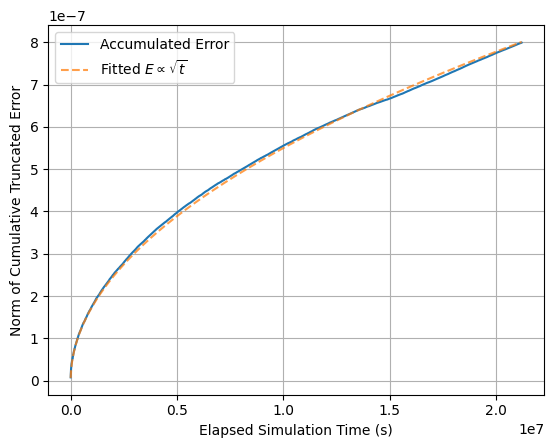

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load data
data = np.load("integration_data.npz")
step_sizes = data["step_sizes"]
global_errors = data["global_errors"]

# Calculate cumulative sums
cumulative_step_sizes = np.cumsum(step_sizes)
cumulative_global_errors = np.sqrt(np.cumsum(global_errors**2))

xs = np.linspace(min(cumulative_step_sizes),max(cumulative_step_sizes),1000)
def f(x,k) :
    return k*x**(1/2)

params, _ = curve_fit(f, cumulative_step_sizes, cumulative_global_errors)
k_fit = params[0]

# Plot the cumulative sums
plt.plot((cumulative_step_sizes), (cumulative_global_errors), linestyle='-',label='Accumulated Error')
plt.plot(xs,f(xs,k_fit),linestyle='--',label=r'Fitted $E\propto\sqrt{t}$',alpha=0.75)
plt.xlabel("Elapsed Simulation Time (s)")
plt.ylabel("Norm of Cumulative Truncated Error")
plt.grid()
plt.legend()
plt.show()